### [2025_12_12]_보스턴 집 가격 예측
- 필수
   * 교차검증
   * 데이터 누수 안됨!
   * 모델 : 회귀 모델,  배깅 앙상블-랜덤포레스트
- 기한 : 주말(12월 14일 일요일까지)

[1] 모듈 로딩 및 데이터 준비 <hr>

In [1]:
# ==================================================
# [1-1] 모듈 로딩
# ==================================================
# 기본 모듈
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import koreanize_matplotlib

# ML 데이터셋 및 학습 관련 모듈
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# ML 모델 성능 지표 관련 모듈
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import root_mean_squared_error, r2_score

# CoW 활성화 : 복사와 공유 자동 설정
pd.options.mode.copy_on_write = True

# 판다스/넘파이에 지수표기법(과학적표기법) 정지 설정
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(precision=6, suppress=True)

In [ ]:
# CRIM   : 지역별 1인당 범죄 발생률
# ZN     : 25,000 제곱피트 초과 대지로 지정된 주거지역 비율
# INDUS  : 비소매업(공업·산업) 용지 비율
# CHAS   : 찰스강 인접 여부 (강과 접해 있으면 1, 아니면 0)
# NOX    : 대기 중 질소산화물 농도 (10백만 분의 1 단위)
# RM     : 주택 1채당 평균 방 개수
# AGE    : 1940년 이전에 건설된 자가주택 비율
# DIS    : 보스턴 주요 고용 중심지까지의 가중 거리
# RAD    : 방사형 고속도로 접근성 지수
# TAX    : 재산세율 (10,000달러당 세금)
# PTRATIO: 학생-교사 비율
# B      : 1000 × (Bk - 0.63)² (Bk는 지역 내 흑인 인구 비율)
# LSTAT  : 저소득층 인구 비율 (%)
# MEDV   : 자가주택 중위 가격 (단위: 천 달러)

In [4]:
# ==================================================
# [1-2] 데이터 준비 및 확인
# ==================================================
# 데이터 준비
columns = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM',
    'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B',
    'LSTAT', 'MEDV'
]

import pandas as pd

DATA_FILE = '../Data/housing.csv'

df = pd.read_csv(
    DATA_FILE,
    sep=r'\s+',        # 공백 기준 분리
    header=None,       # 컬럼명이 파일에 없음
    names=columns
)

display(df.head())
df.info()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.00000,2.31000,0,0.53800,6.57500,65.20000,4.09000,1,296.00000,15.30000,396.90000,4.98000,24.00000
1,0.02731,0.00000,7.07000,0,0.46900,6.42100,78.90000,4.96710,2,242.00000,17.80000,396.90000,9.14000,21.60000
2,0.02729,0.00000,7.07000,0,0.46900,7.18500,61.10000,4.96710,2,242.00000,17.80000,392.83000,4.03000,34.70000
3,0.03237,0.00000,2.18000,0,0.45800,6.99800,45.80000,6.06220,3,222.00000,18.70000,394.63000,2.94000,33.40000
4,0.06905,0.00000,2.18000,0,0.45800,7.14700,54.20000,6.06220,3,222.00000,18.70000,396.90000,5.33000,36.20000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [ ]:
## 상관계수 보기
corr = df.corr()

## 타겟 컬럼인 MEDV기준으로 상관계수 높은 순서대로 보기
corr_medv = corr['MEDV']
corr_medv.loc[corr_medv.abs().sort_values(ascending=False).index]

MEDV       1.00000
LSTAT     -0.73766
RM         0.69536
PTRATIO   -0.50779
INDUS     -0.48373
TAX       -0.46854
NOX       -0.42732
CRIM      -0.38830
RAD       -0.38163
AGE       -0.37695
ZN         0.36045
B          0.33346
DIS        0.24993
CHAS       0.17526
Name: MEDV, dtype: float64

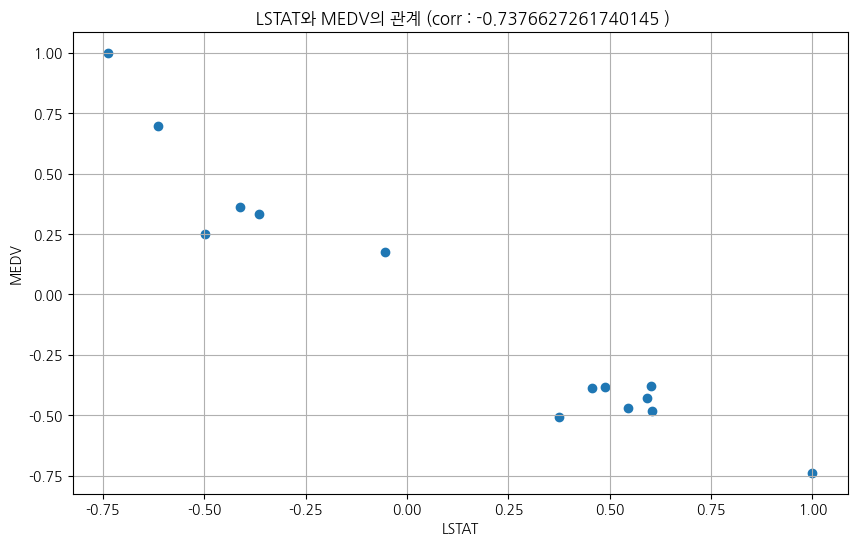

In [11]:
# => 시각화
plt.figure(figsize = (10, 6))
plt.scatter(corr.LSTAT, corr.MEDV)
plt.title(f" LSTAT와 MEDV의 관계 (corr : {corr_medv.LSTAT} )")
plt.xlabel('LSTAT')
plt.ylabel('MEDV')
plt.grid()
plt.show()

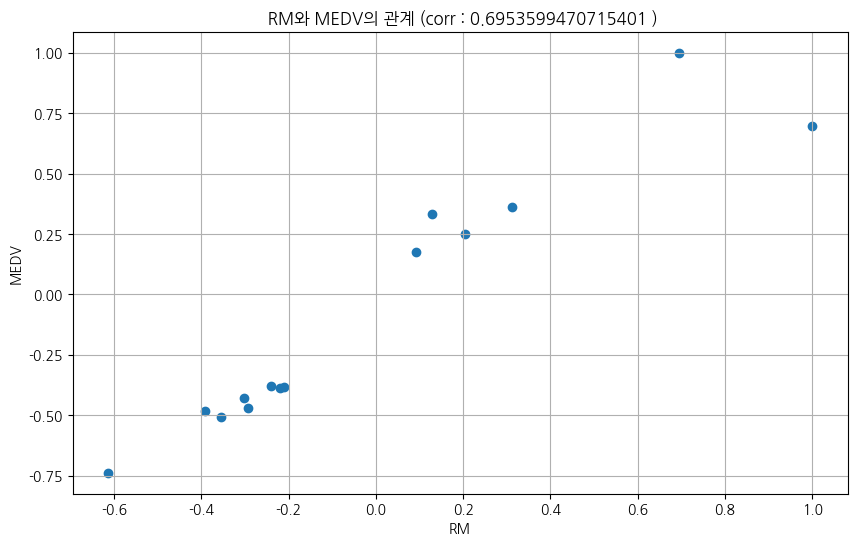

In [12]:
# => 시각화
plt.figure(figsize = (10, 6))
plt.scatter(corr.RM, corr.MEDV)
plt.title(f" RM와 MEDV의 관계 (corr : {corr_medv.RM} )")
plt.xlabel('RM')
plt.ylabel('MEDV')
plt.grid()
plt.show()

In [14]:
# [2-1] 피처(2D)와 타겟(1D) 분리 
# 피처 : 요소들, 타겟 : MEDV(자가주택 중위 가격)
featureDF = df[df.columns[0:-1]]    
targetSR = df[df.columns[-1]]        # MEDV

print(f'featureDF : {featureDF.shape}, targetSR : {targetSR.shape}')
featureDF.head(3)

featureDF : (506, 13), targetSR : (506,)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.00000,2.31000,0,0.53800,6.57500,65.20000,4.09000,1,296.00000,15.30000,396.90000,4.98000
1,0.02731,0.00000,7.07000,0,0.46900,6.42100,78.90000,4.96710,2,242.00000,17.80000,396.90000,9.14000
2,0.02729,0.00000,7.07000,0,0.46900,7.18500,61.10000,4.96710,2,242.00000,17.80000,392.83000,4.03000


In [15]:
# [2-2] 학습용과 테스트용 분리 : 회귀 시에는 stratify 필요 없음, 
#                             분류 시에는 클래스/라벨별 비율 설정을 위해서 stratify 필요!
x_train, x_test, y_train, y_test = train_test_split(featureDF,
                                                    targetSR, 
                                                    test_size=0.2,
                                                    random_state=10,
)
print(f'[TRAIN]  x_train : {x_train.shape}, y_train : {y_train.shape}')
print(f'[TEST]  x_test : {x_test.shape}, y_test : {y_test.shape}')

[TRAIN]  x_train : (404, 13), y_train : (404,)
[TEST]  x_test : (102, 13), y_test : (102,)


[3] 학습 진행 <hr>

In [16]:
# 모델 인스턴스 생성
lrModel = LinearRegression()
lrModel

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [17]:
# 학습 진행 -> 학습용 데이터 셋만 사용(train)
lrModel.fit(x_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [19]:
# 학습 후 학습용 데이터셋 기반 모델 파라미터 설정
# - 모델 파라미터 : 파라미터이름_ = 피쳐에 곱해지는 가중치 W, 결과 미세조정 절편 bias
print('가중치 coef_ :', lrModel.coef_)
print('절편 intercept_ :',lrModel.intercept_)
print('feature_names_in_ :',lrModel.feature_names_in_)
print('n_features_in_ :',lrModel.n_features_in_)

가중치 coef_ : [ -0.128181   0.063198  -0.007576   1.974515 -16.271989   3.108456
   0.016292  -1.483014   0.303988  -0.012082  -0.820306   0.011419
  -0.581626]
절편 intercept_ : 36.533051382824354
feature_names_in_ : ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
n_features_in_ : 13


In [ ]:
# 훈련용 성능평가 & 테스트용 성능평가 비교
train_score = lrModel.score(x_train, y_train)
test_score = lrModel.score(x_test, y_test)

print(f'[train_score] {train_score}')
print(f'[test_score] {test_score}')

[train_score] 0.750121534530608
[test_score] 0.670933983911563


In [21]:
# ============================================
# 다양한 회귀 모델 성능지표 확인
# ============================================
# => 예측값과 실제값 함수에 전달
pre_score = lrModel.predict(x_test)

# => 성능 지표 계산
# => 에러/오차/잔차 : 값이 0에 가까울수록 좋음
print("MAE : ", mean_absolute_error(y_test, pre_score))
print("MSE : ", mean_squared_error(y_test, pre_score))
print("RMSE : ", root_mean_squared_error(y_test, pre_score))

# => 회귀선이 얼마나 데이터를 잘 설명/표현하는가? -> 값이 1에 가까울수록 좋음
print("R2 : ", r2_score(y_test, pre_score))     # => 회귀모델.score()에서 사용하는 계산 값

MAE :  4.061419182954708
MSE :  34.413968453138544
RMSE :  5.866341999333021
R2 :  0.670933983911563


In [ ]:
## ================================================
## 선형회귀 + 파이프라인 + 교차검증
## ================================================
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# 파이프라인 구성 (전처리 + 모델)
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),   # 수치형 → 스케일링
    ('lr', LinearRegression())
])

# 교차검증 수행
cv_result = cross_validate(
    pipe_lr,
    featureDF,
    targetSR,
    cv=5,
    scoring=['r2', 'neg_mean_squared_error'],
    return_train_score=True
)

# 결과 출력
print("Train R2 평균 :", cv_result['train_r2'].mean())
print("Test  R2 평균 :", cv_result['test_r2'].mean())
print("Test  RMSE 평균 :", 
      np.sqrt(-cv_result['test_neg_mean_squared_error']).mean())


Train R2 평균 : 0.7492806811079173
Valid R2 평균 : 0.35327592439588146
Valid RMSE 평균 : 5.828658946215808


In [ ]:
## ================================================
## RandomForest 회귀 + 교차검증
## ================================================
from sklearn.ensemble import RandomForestRegressor

pipe_rf = Pipeline([
    ('rf', RandomForestRegressor(
        n_estimators=200,
        random_state=42
    ))
])

cv_result_rf = cross_validate(
    pipe_rf,
    featureDF,
    targetSR,
    cv=5,
    scoring='r2',
    return_train_score=True
)

print("RF Train R2 평균 :", cv_result_rf['train_score'].mean())
print("RF Test  R2 평균 :", cv_result_rf['test_score'].mean())


RF Train R2 평균 : 0.9823202866565209
RF Valid R2 평균 : 0.626465526787165
